In [6]:
import pandas as pd
import seaborn
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import decomposition
import potential_data
import scaler
import plots
import potential_analyze
import fit

pd.options.mode.chained_assignment = None

In [7]:
def read_functional(paths):
    df = []
    for path in paths:
        for i in range(path['conf_range'][0], path['conf_range'][1] + 1):
            data_path = path['path'] + f'_{i:04}'
            if(os.path.isfile(data_path)):
                df1 = pd.read_csv(data_path)
                if not df1.empty:
                    df.append(df1)
                    df[-1]['conf'] = i
                    if 'copy' in df[-1]:
                        if df[-1].loc[0, 'copy'] == 0:
                            df[-1]['copy'] = df[-1]['copy'] + 1
                    if 'parameters' in path:
                            for key, val in path['parameters'].items():
                                df[-1][key] = val
    return pd.concat(df)

def fill_funcational_max(df, groupby_keys):
    df2 = []
    copy_num = df.groupby(['copy']).ngroups
    for copy_max in range(1, copy_num + 1):
        df1 = df[df['copy'] <= copy_max]
        df1 = df1.groupby(groupby_keys + ['conf'])['functional'].max().reset_index(level=groupby_keys + ['conf'])
        df2.append(df1.groupby(groupby_keys)['functional']\
                   .agg([('functional', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys))
        df2[-1]['copy'] = copy_max
    return pd.concat(df2)

In [10]:
# fit linear string tension for each copy and plot string tension
# dependence on average functional of gauge copy
def string_tension_copy(paths_potential, paths_functional, image_path_potential, image_name_potential, image_path_functional, image_name_functional):
    data = potential_data.get_potantial_df(paths_potential)
    data = data.drop('T', axis = 1)
    # df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (5, 12), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
    #                 .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
    fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
    fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
    fit_params['sigma'] = np.sqrt(fit_params['sigma'])
    df_func = read_functional(paths_functional)
    df_func = fill_funcational_max(df_func, ['steps'])
    fit_params = fit_params.merge(df_func, how='inner', on=['steps', 'copy'])
    plots.plot_potential_single(data, 'r/a', 'aV(r)', 'err', 'copy', 'r/a', 'aV(r)', 'original potential', image_path_potential, image_name_potential, True)
    plots.plot_potential_single(fit_params, 'functional', 'sigma', 'sigma_err', None, 'functional', 'sigma', 'string tension', image_path_functional, image_name_functional, True)

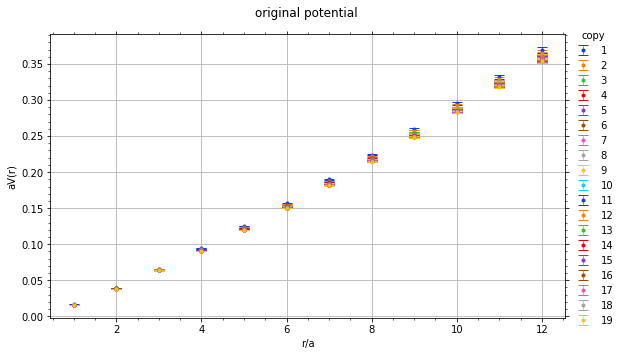

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//copy_comparison


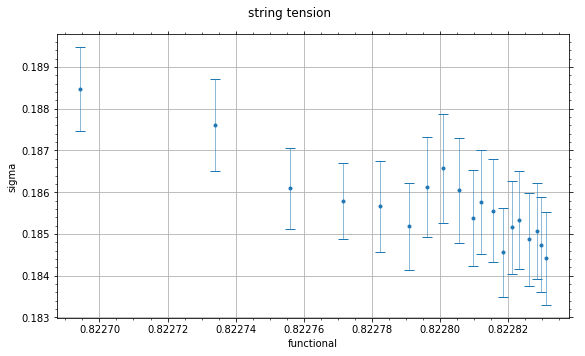

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//string_tension_functional


In [11]:
paths_potential = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_100/copies=20/0.01/potential_monopole.csv',
          'parameters': {'beta': 6.0, 'steps': 100}, 'constraints': {'r/a': (1, 12), 'T': (10, 10)}}]
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 100}}]
image_path_potential = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/'
image_name_potential = f'copy_comparison'
image_path_functional = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/'
image_name_functional = 'string_tension_functional'
string_tension_copy(paths_potential, paths_functional, image_path_potential, image_name_potential, image_path_functional, image_name_functional)

    copy  beta        V0    V0_err     alpha  alpha_err     sigma  sigma_err  \
0      1   6.0 -0.070758  0.003500  0.090771   0.007413  0.035521   0.000379   
1      2   6.0 -0.070871  0.003784  0.091756   0.007994  0.035199   0.000411   
2      3   6.0 -0.067968  0.003304  0.086816   0.006985  0.034631   0.000359   
3      4   6.0 -0.067580  0.003130  0.086094   0.006612  0.034517   0.000340   
4      5   6.0 -0.068512  0.003728  0.088493   0.007866  0.034472   0.000406   
5      6   6.0 -0.067812  0.003548  0.087488   0.007510  0.034294   0.000385   
6      7   6.0 -0.070443  0.004122  0.092175   0.008712  0.034641   0.000448   
7      8   6.0 -0.071903  0.004511  0.094917   0.009526  0.034808   0.000491   
8      9   6.0 -0.070932  0.004321  0.093374   0.009138  0.034612   0.000469   
9     10   6.0 -0.069167  0.003931  0.090096   0.008319  0.034367   0.000426   
10    11   6.0 -0.070486  0.004254  0.092589   0.009003  0.034509   0.000461   
11    12   6.0 -0.069963  0.004234  0.09

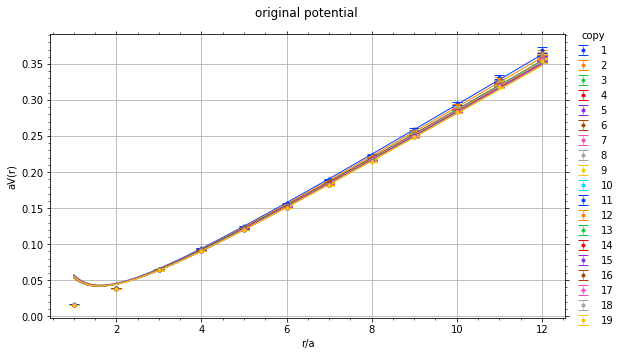

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//copy_comparison


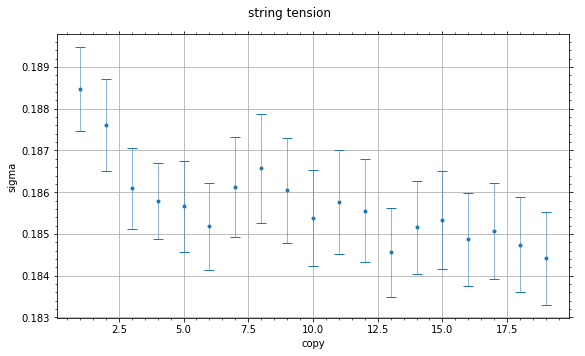

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20//string_tension


In [12]:
show_plot = True
coordinate = 'r/a'
hue = 'copy'
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_100/copies=20/0.01/potential_monopole.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 12), 'T': (10, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/'
image_name = f'copy_comparison'
data = potential_data.get_potantial_df(paths)
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
plots.plot_potential_single(fit_params, 'copy', 'sigma', 'sigma_err', None, 'copy', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=4000/copies=20/', 'string_tension', show_plot)

    copy  beta        V0    V0_err     sigma  sigma_err    chi_sq
0      1   6.0 -0.028802  0.002197  0.031213   0.000531  0.002555
1      2   6.0 -0.028072  0.002127  0.030735   0.000516  0.002428
2      3   6.0 -0.027810  0.002098  0.030484   0.000506  0.002311
3      4   6.0 -0.027664  0.002070  0.030386   0.000501  0.002256
4      5   6.0 -0.027263  0.002081  0.030158   0.000504  0.002398
5      6   6.0 -0.027471  0.002142  0.030168   0.000516  0.002537
6      7   6.0 -0.027732  0.002188  0.030233   0.000528  0.002662
7      8   6.0 -0.027694  0.002211  0.030203   0.000534  0.002821
8      9   6.0 -0.027557  0.002188  0.030118   0.000529  0.002711
9     10   6.0 -0.027371  0.002122  0.030046   0.000512  0.002482
10    11   6.0 -0.027420  0.002125  0.030037   0.000511  0.002441
11    12   6.0 -0.027474  0.002140  0.030048   0.000514  0.002511
12    13   6.0 -0.027383  0.002141  0.029989   0.000514  0.002500
13    14   6.0 -0.027632  0.002191  0.030065   0.000526  0.002608
14    15  

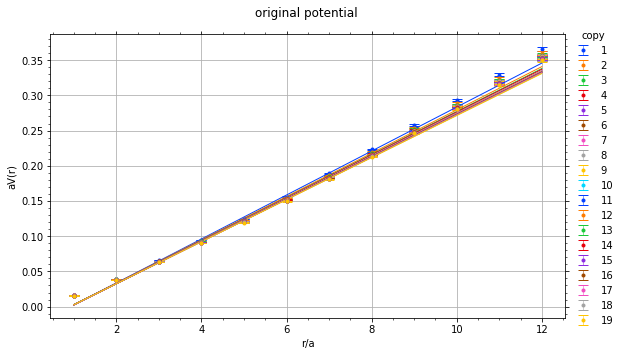

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20//copy_comparison


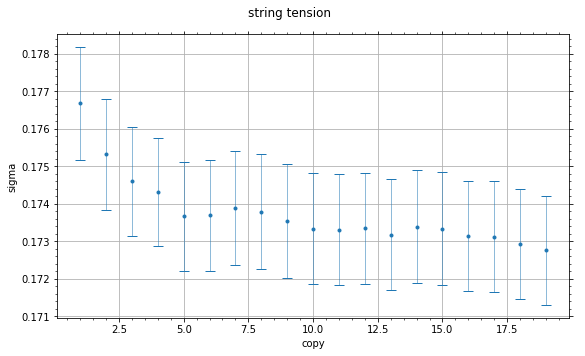

../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20//string_tension


In [19]:
show_plot = True
coordinate = 'r/a'
hue = 'copy'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_100/copies=20/0.01/potential_monopole.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 12), 'T': (8, 8)}}]
image_path = f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20/'
image_name = f'copy_comparison'
data = potential_data.get_potantial_df(paths)
# data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (1, 12)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (3, 12), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (3, 12), fit.func_linear, ['V0', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
# plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot)
# x_fit = np.linspace(6, 6.4, 1000)
# y_fit = scaler.get_a_sqrt_sigma(x_fit)
# df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
# df_string_tension_fit['fit'] = 'fit'
# fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'copy', 'sigma', 'sigma_err', None, 'copy', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/24^4/beta6.0/steps=100/copies=20/', 'string_tension', show_plot)
# plots.plot_potential_single(fit_params, 'beta', 'alpha', 'alpha_err', 'fit', 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/gluodynamics/', 'coulomb_coefficient', show_plot, black_line_y=-math.pi/12)

   copy  beta  size        V0    V0_err     alpha  alpha_err     sigma  \
0     0   6.0  16^4  0.148447  0.001162 -0.253707   0.001497  0.047537   
1     0   6.0  24^4  0.143821  0.000631 -0.248372   0.000807  0.048485   
2     0   6.0  32^4  0.143902  0.000708 -0.248506   0.000943  0.048479   

   sigma_err    chi_sq  
0   0.000211  0.000007  
1   0.000116  0.000028  
2   0.000123  0.000028  
   copy  beta  size        V0    V0_err     alpha  alpha_err     sigma  \
0     0   6.0  16^4  0.148447  0.001162 -0.253707   0.001497  0.218030   
1     0   6.0  24^4  0.143821  0.000631 -0.248372   0.000807  0.220193   
2     0   6.0  32^4  0.143902  0.000708 -0.248506   0.000943  0.220181   

   sigma_err    chi_sq  
0   0.000485  0.000007  
1   0.000264  0.000028  
2   0.000279  0.000028  


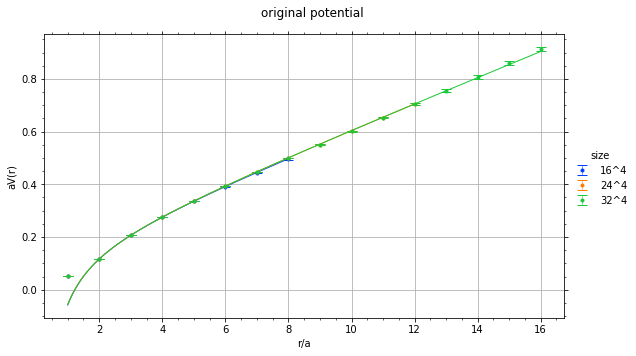

../../images/potential/su3/gluodynamics//size_comparison


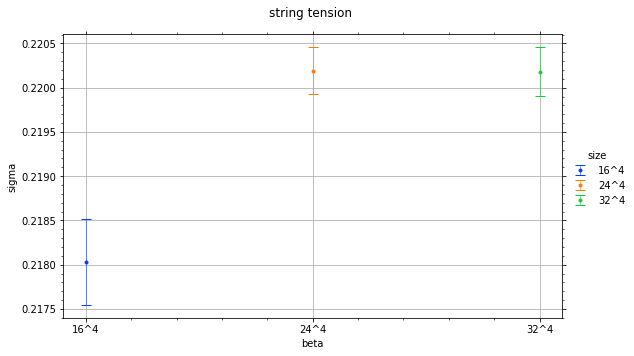

../../images/potential/su3/gluodynamics//string_tension_beta=6p0


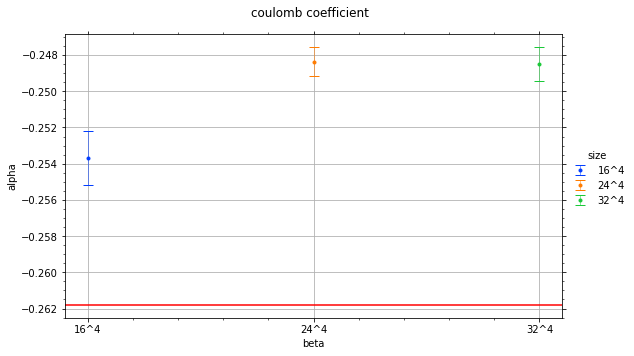

../../images/potential/su3/gluodynamics//coulomb_coefficient_beta=6p0


In [25]:
show_plot = True
coordinate = 'r/a'
hue = 'size'
groupby = []
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0, 'size': '16^4'}, 'constraints': {'r/a': (1, 8), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0, 'size': '24^4'}, 'constraints': {'r/a': (1, 12), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0, 'size': '32^4'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
#           'parameters': {'beta': 6.0, 'size': '16^4'}, 'constraints': {'r/a': (1, 12), 'T': (1, 10)}},
#           {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
#           'parameters': {'beta': 6.0, 'size': '24^4'}, 'constraints': {'r/a': (1, 12), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (2, 10)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (2, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (2, 12), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
#x_fit = np.linspace(6, 6.4, 1000)
#y_fit = scaler.get_a_sqrt_sigma(x_fit)
#df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
#df_string_tension_fit['fit'] = 'fit'
#fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'size', 'sigma', 'sigma_err', hue, 'beta', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/', 'string_tension_beta=6p0', show_plot)
plots.plot_potential_single(fit_params, 'size', 'alpha', 'alpha_err', hue, 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/gluodynamics/', 'coulomb_coefficient_beta=6p0', show_plot,  black_line_y=-math.pi/12)

/home/ilya/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


   beta        V0    V0_err     alpha  alpha_err     sigma  sigma_err  \
0   6.0  0.118551  0.013097 -0.131336   0.060550  0.049637   0.000701   
1   6.1  0.150264  0.007813 -0.196525   0.036971  0.035074   0.000406   
2   6.2  0.164577  0.001069 -0.231000   0.005550  0.025784   0.000049   
3   6.3  0.177517  0.000609 -0.278558   0.003193  0.019054   0.000028   
4   6.4  0.179326  0.000743 -0.279702   0.003986  0.014366   0.000033   

         chi_sq  
0  5.601038e-07  
1  3.061329e-06  
2  5.434618e-08  
3  1.979669e-07  
4  3.340164e-07  
   beta        V0    V0_err     alpha  alpha_err     sigma  sigma_err  \
0   6.0  0.118551  0.013097 -0.131336   0.060550  0.222793   0.001573   
1   6.1  0.150264  0.007813 -0.196525   0.036971  0.187280   0.001084   
2   6.2  0.164577  0.001069 -0.231000   0.005550  0.160573   0.000153   
3   6.3  0.177517  0.000609 -0.278558   0.003193  0.138038   0.000101   
4   6.4  0.179326  0.000743 -0.279702   0.003986  0.119856   0.000138   

         chi_s

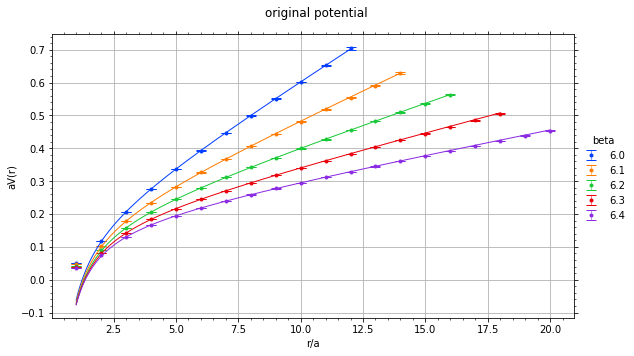

../../images/potential/su3/gluodynamics//beta_comparison


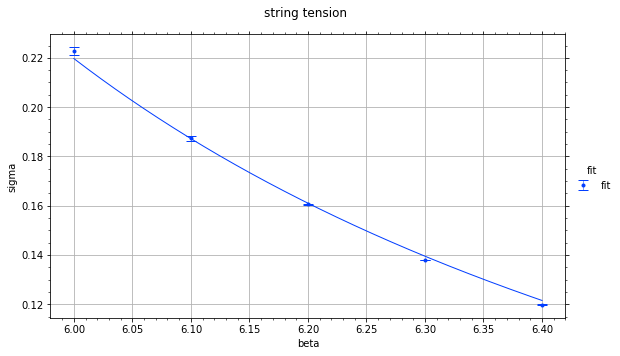

../../images/potential/su3/gluodynamics//string_tension


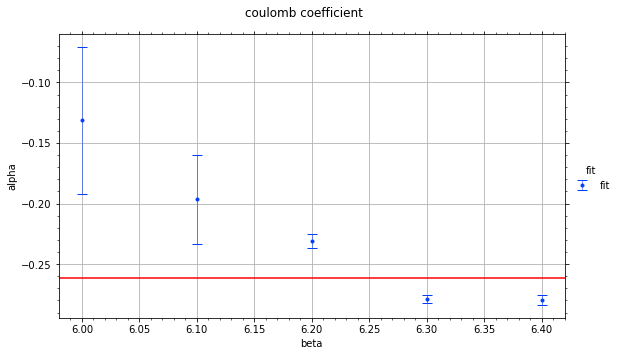

../../images/potential/su3/gluodynamics//coulomb_coefficient


In [32]:
show_plot = True
coordinate = 'r/a'
hue = 'beta'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 12), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/28^4/beta6.1/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.1}, 'constraints': {'r/a': (1, 14), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.2}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.3}, 'constraints': {'r/a': (1, 18), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/40^4/beta6.4/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.4}, 'constraints': {'r/a': (1, 20), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/'
image_name = f'beta_comparison'
data = potential_data.get_potantial_df(paths)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (2, 10)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (3, 18), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (8, 18), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index(drop=True)
print(fit_params)
fit_params['sigma_err'] = fit_params['sigma_err']/(2*np.sqrt(fit_params['sigma']))
fit_params['sigma'] = np.sqrt(fit_params['sigma'])
# print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)
x_fit = np.linspace(6, 6.4, 1000)
y_fit = scaler.get_a_sqrt_sigma(x_fit)
df_string_tension_fit = pd.DataFrame({'beta': x_fit, 'sigma': y_fit})
df_string_tension_fit['fit'] = 'fit'
fit_params['fit'] = 'fit'
plots.plot_potential_single(fit_params, 'beta', 'sigma', 'sigma_err', 'fit', 'beta', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/', 'string_tension', show_plot, df_fits=df_string_tension_fit)
plots.plot_potential_single(fit_params, 'beta', 'alpha', 'alpha_err', 'fit', 'beta', 'alpha', 'coulomb coefficient', f'../../images/potential/su3/gluodynamics/', 'coulomb_coefficient', show_plot, black_line_y=-math.pi/12)

         beta  size        r/a     aV(r)
0    beta=6.0  24^4   1.000000  0.381979
1    beta=6.0  24^4   1.011011  0.386154
2    beta=6.0  24^4   1.022022  0.390249
3    beta=6.0  24^4   1.033033  0.394268
4    beta=6.0  24^4   1.044044  0.398213
..        ...   ...        ...       ...
995  beta=6.0  24^4  11.955956  1.198519
996  beta=6.0  24^4  11.966967  1.199055
997  beta=6.0  24^4  11.977978  1.199592
998  beta=6.0  24^4  11.988989  1.200129
999  beta=6.0  24^4  12.000000  1.200665

[1000 rows x 4 columns]
       beta  size        V0    V0_err     alpha  alpha_err     sigma  \
0  beta=6.0  24^4  0.679177  0.006382 -0.349226   0.014163  0.045581   

   sigma_err    chi_sq  
0   0.000545  0.000055  
0.2134962778954389


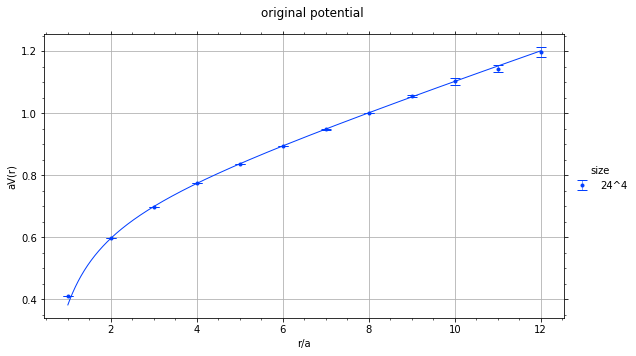

../../images/potential/su3/gluodynamics/beta6.0//size_comparison


In [3]:
show_plot = True
coordinate = 'r/a'
hue = 'size'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/24^4/beta6.0/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.0', 'size': '24^4'}, 'constraints': {'r/a': (1, 12), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/beta6.0/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (2, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
print(df_fit)
print(fit_params)
fit_params = fit_params.reset_index()
print(math.sqrt(fit_params.at[0, 'sigma']))
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

   index      beta     size        V0    V0_err     alpha  alpha_err  \
0      0  beta=6.2  32^3x64  0.645419  0.003120 -0.322844   0.007939   
1      0  beta=6.2     32^4  0.638481  0.001475 -0.310809   0.003753   

      sigma  sigma_err    chi_sq  
0  0.024667   0.000216  0.000045  
1  0.025398   0.000102  0.000012  
0.1593676579186971 0.0003197910388366388


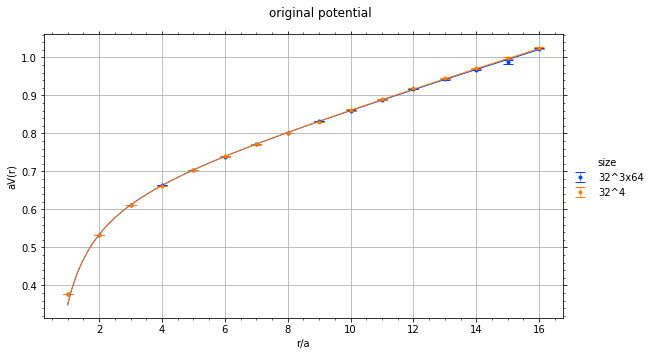

../../images/potential/su3/gluodynamics/beta6.2//size_comparison


In [9]:
show_plot = True
coordinate = 'r/a'
hue = 'size'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^4/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'size': '32^4'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'size': '32^3x64'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/beta6.2/'
image_name = f'size_comparison'
data = potential_data.get_potantial_df(paths)
data = data.groupby(list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])])).apply(fit.potential_fit_T, (2, 8)).reset_index(level=list(data.columns[~data.columns.isin(['T', 'aV(r)', 'err'])]))
data = data.drop('T', axis = 1)
df_fit = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.potential_fit_data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])]))
fit_params = data.groupby(list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).apply(fit.make_fit, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)\
                    .reset_index(level=list(data.columns[~data.columns.isin(['r/a', 'aV(r)', 'err'])])).reset_index()
print(fit_params)
print(math.sqrt(fit_params.at[1, 'sigma']), fit_params.at[1, 'sigma_err']/(2*math.sqrt(fit_params.at[1, 'sigma'])))
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'r/a', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

         V0    V0_err     alpha  alpha_err     sigma  sigma_err    chi_sq
0  0.638481  0.001475 -0.310809   0.003753  0.025398   0.000102  0.000012


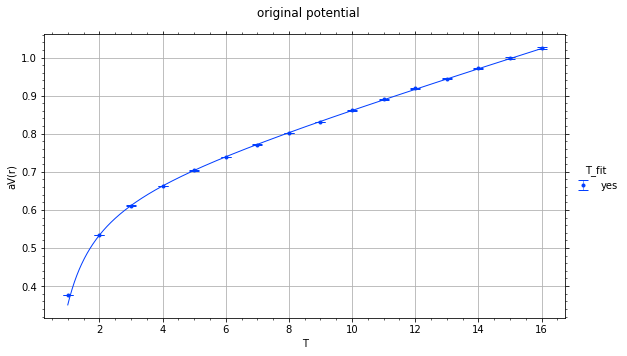

../../images/potential/su3/gluodynamics/32^4/beta6.2//potential_orignal


In [9]:
show_plot = True
coordinate = 'r/a'
hue = 'T_fit'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^4/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'potential_type': 'original', 'smearing': 'APE'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/32^4/beta6.2/'
image_name = f'potential_orignal'
data = potential_data.get_potantial_df(paths)
data = data.groupby('r/a').apply(fit.potential_fit_T, (2, 8)).reset_index(level='r/a')
data['T_fit'] = 'yes'
data['potential_type'] = 'original'
df_fit = fit.potential_fit_data(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')
df_fit['potential_type'] = 'original'
fit_params = fit.make_fit(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'T', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

         V0   V0_err     alpha  alpha_err     sigma  sigma_err    chi_sq
0  0.645419  0.00312 -0.322844   0.007939  0.024667   0.000216  0.000045


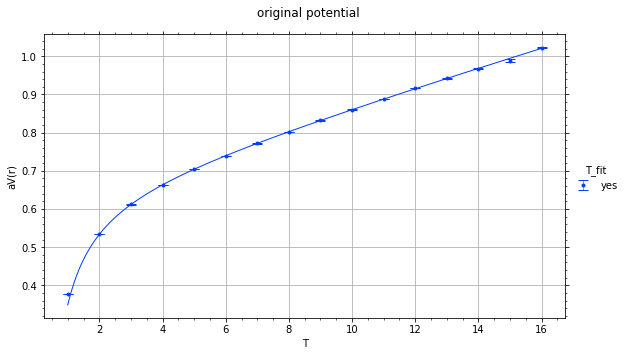

../../images/potential/su3/gluodynamics/32^3/beta6.2//potential_orignal


In [7]:
show_plot = True
coordinate = 'r/a'
hue = 'T_fit'
groupby = []
# paths = [{'path': '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/32^3x64/beta6.2/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_original.csv',
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'potential_type': 'original', 'smearing': 'APE'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/32^3x64/beta6.2/'
image_name = f'potential_orignal'
data = potential_data.get_potantial_df(paths)
data = data.groupby('r/a').apply(fit.potential_fit_T, (2, 8)).reset_index(level='r/a')
data['T_fit'] = 'yes'
data['potential_type'] = 'original'
df_fit = fit.potential_fit_data(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err')
df_fit['potential_type'] = 'original'
fit_params = fit.make_fit(data, (2, 16), fit.func_quark_potential, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col=None)
print(fit_params)
plots.plot_potential_single(data, coordinate, 'aV(r)', 'err', hue, 'T', 'aV(r)', 'original potential', image_path, image_name, show_plot, df_fits=df_fit)

In [10]:
# plot potential T dependence for each r
def plot_T_dependence(paths, image_path, show_plot, fit=None):
    data = potential_data.get_potantial_df(paths)
    data['fit'] = 'T_fit'
    if fit != None:
        df_fits = data.groupby('r/a').apply(fit.potential_fit_data, (2, 8), fit.func_exponent,['C', 'b', 'V'], 'T', 'aV(r)', err_col='err').reset_index(level='r/a')
        df_fits['fit'] = 'T_fit'
    for r in data['r/a'].unique():
        if fit == None:
            fit1 = None
        else:
            fit1 = df_fits[df_fits['r/a'] == r]
        plots.plot_potential_single(data[data['r/a'] == r], 'T', 'aV(r)', 'err', 'fit', 'T', 'aV(r)', 'original potential', image_path, f'potential_T_dependence_r={r}', show_plot, fit1)

In [11]:
show_plot = False
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'potential_type': 'original', 'smearing': 'APE'}, 'constraints': {'r/a': (1, 16), 'T': (1, 10)}}]
image_path = f'../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit'
plot_T_dependence(paths, image_path, show_plot)

../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=1
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=2
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=3
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=4
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=5
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=6
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=7
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=8
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/original

In [12]:
show_plot = False
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/40^4/beta6.4/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 'beta=6.2', 'potential_type': 'original', 'smearing': 'HYP_APE'}, 'constraints': {'r/a': (1, 20), 'T': (1, 14)}}]
image_path = f'../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit'
plot_T_dependence(paths, image_path, show_plot)

../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/potential_T_dependence_r=1
../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/potential_T_dependence_r=2
../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/potential_T_dependence_r=3
../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/potential_T_dependence_r=4
../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/potential_T_dependence_r=5
../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/potential_T_dependence_r=6
../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/potential_T_dependence_r=7
../../images/potential/su3/gluodynamics/40^4/beta6.4/original/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_fit/pot

In [14]:
show_plot = False
paths = [{'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/32^3x64/beta6.2/HYP0_APE_alpha=0.5/steps_500/copies=4/potential_monopole.csv',
          'parameters': {'beta': 'beta=6.2', 'potential_type': 'original', 'smearing': 'APE'}, 'constraints': {'r/a': (1, 16), 'T': (1, 31)}}]
image_path = f'../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit'
plot_T_dependence(paths, image_path, show_plot)

../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=1
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=2
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=3
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=4
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=5
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=6
../../images/potential/su3/gluodynamics/32^3x64/beta6.2/monopole/steps_500/copies=4/HYP0_APE_alpha=0.5/T_fit/potential_T_dependence_r=7
../../images/potential/su3/gluodynamics/32^3x64/